In [ ]:
import pandas as pd
import pickle as pkl
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from create_datasets.create_table_datasets import adni_data
from ml_models.machine_learning_models import create_class_ADNI, main, baseline_model

Create table datasets (with and without APOE) for the targets and genes of interest to use as input for more-standard machine learning models.

In [ ]:
diseases = ['AD', 'ND']

for disease in diseases:

    infile1 = f'data/ADNI/{disease}_PPI_missense.csv'
    infile2 = 'data/ADNI/ADNIMERGE_genetics_biomarkers.csv'

    table_dataset = adni_data('missense', disease, infile1, infile2)
    table_dataset.to_csv(f'data/table_datasets/{disease}_PPI_missense_with_biomarkers.csv')

In [ ]:
targets = ['PET', 'PETandDX']
diseases = ['AD', 'ND']

for target in targets:
    for disease in diseases:

        infile = f'data/table_datasets/{disease}_PPI_missense_with_biomarkers.csv'
        data = pd.read_csv(infile, index_col = 0)
        data_wclass = create_class_ADNI(data, target)

        x = data_wclass.drop(columns=['y'])
        x = x['APOE']

        y = data_wclass['y']
        x.index = x.index.str.upper()

        f = open(f'data/splits/split_{target}.pkl', 'rb')
        split_pet = pkl.load(f)
        f.close()

        auc_pet = baseline_model(split_pet, x, y)
        print('Baseline model PET, AUC ROC:', auc_pet)

Run more-standard machine learning models 3 times (to properly compare with the 3 runs for each GNN model).

In [ ]:
targets = ['PET', 'PETandDX']
diseases = ['AD', 'ND']

for target in targets:
    for disease in diseases:
        for i in range(1, 4):
            result_ad = main('ADNI', disease, 'PPI', target, 'data/table_datasets', f'results/results_missense_PET_rep{i}')
            result_ad_noAPOE = main('ADNI_noAPOE', disease, 'PPI', target, 'data/table_datasets', f'results/results_missense_PET_noAPOE_rep{i}')

Joint results of both baseline, no-GNN, and GNN models are in `results/ML_models_comparison` directory.

Next lines plot the results obtained for PET and PET&DX targets in ADNI dataset (Figure 2 of the paper).

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# plt.style.use('ggplot')
sns.set(font="Helvetica")

In [17]:
def barplot_comparision_ml(target, bs, df, metric):
    
    colors = ["#F8766D", "#a3a500", "#00bf7d", "#00b0f6", "#E76BF3"]
#     colors = ["#D39200", "#00B9E3", "#F8766D", "#00BA38", "#DB72FB"]
    custom = sns.set_palette(sns.color_palette(colors))
#     custom=sns.color_palette("bright", 5)

    plt.figure(figsize=(8, 8))
    ax = sns.barplot(x = 'Dataset',
                     y = metric,
                     hue = 'Model',
                     ci = 'sd',
                     data = df,
                     palette = custom)
    plt.axhline(y=bs, color='r', linestyle='dotted', label=f'Baseline model ({bs})')
    plt.legend(fontsize=14, loc='upper right')
    plt.ylim(0, 1.0)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.xaxis.label.set_visible(False)
#     plt.xlabel('Dataset', fontsize=16)
    plt.ylabel(f'{metric} obtained in test set', fontsize=16)
    plt.tight_layout(True)
    
    plt.savefig(f'figures/{target}_{metric}_comp_barplot.pdf', dpi=500)
    plt.savefig(f'figures/{target}_{metric}_comp_barplot.png', dpi=500)

/home/laura/anaconda3/envs/graphgym/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


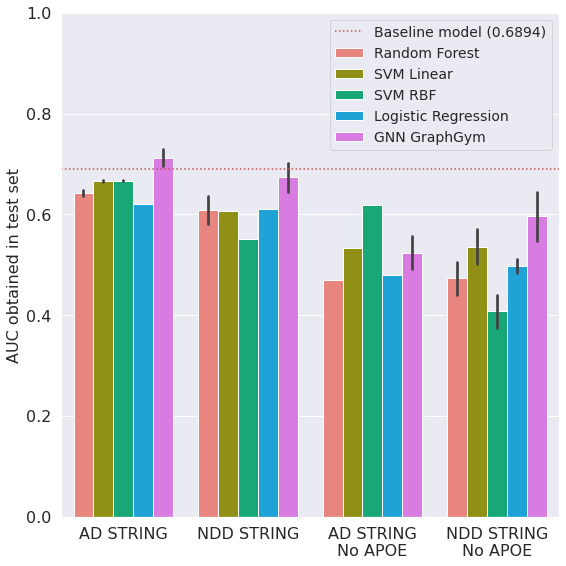

In [18]:
pet_results = pd.read_csv('results/ML_models_comparison/2022_01_PET.csv')
pet_baseline = pet_results.iloc[60]
pet_results.drop([60], inplace=True)

barplot_comparision_ml('PET', pet_baseline['AUC'], pet_results, 'AUC')

/home/laura/anaconda3/envs/graphgym/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


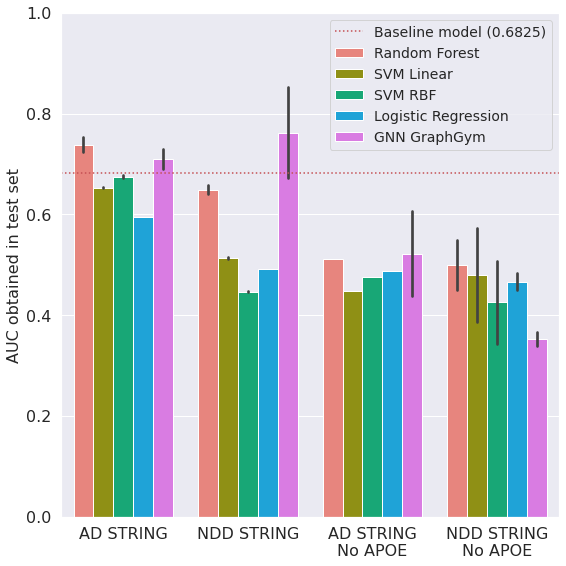

In [19]:
petdx_results = pd.read_csv('results/ML_models_comparison/2022_01_PETandDX.csv')
petdx_baseline = petdx_results.iloc[60]
petdx_results.drop([60], inplace=True)

barplot_comparision_ml('PET&DX', petdx_baseline['AUC'], petdx_results, 'AUC')